In [29]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [20]:
df = pd.read_csv('../../../traces/workload_traces/workloads.csv')
df = df[df['platform'] == 'platform-0']
df.head()

,dataset,family,algorithm,platform,run,duration,schedulerDelay,executorRunTime,executorCpuTime,executorDeserializeTime,...,peakExecutionMemory,bytesRead,shuffleFetchWaitTime,shuffleTotalBytesRead,shuffleTotalBlocksFetched,shuffleLocalBlocksFetched,shuffleRemoteBlocksFetched,shuffleWriteTime,shuffleBytesWritten,fitTime
25,DHG,clustering,BKM,platform-0,0,17659195,128151,17384950,11387091,145831,...,167220911,184898948086,11,4147111,6880,172,6708,1225,4147111,154268.0
86,DHG,clustering,KM,platform-0,0,2460043,166627,2144081,1271561,148948,...,166841115,93470581548,17,3325656,8000,200,7800,1557,3325656,23986.0
147,DHG,clustering,GMM,platform-0,0,3978738,65534,3811085,2722073,101836,...,187344416,71467580940,65,22957409,3360,88,3272,1382,22957409,41089.0
208,DHG,classification,MLP,platform-0,0,28939205,230008,28464293,27159748,244315,...,11525196032,222962779362,1087,439793063,18080,442,17638,426,439793063,201822.0
269,DHG,classification,DT,platform-0,0,4076430,84125,3890030,2411518,101949,...,46499059786,48354541616,16113,483366273,96480,2412,94068,2941,483366273,37718.0


In [21]:
features = list(df.columns)[5:]
x = df.loc[:, features]
x = StandardScaler().fit_transform(x.values)
labels = list(df.dataset + df.algorithm)

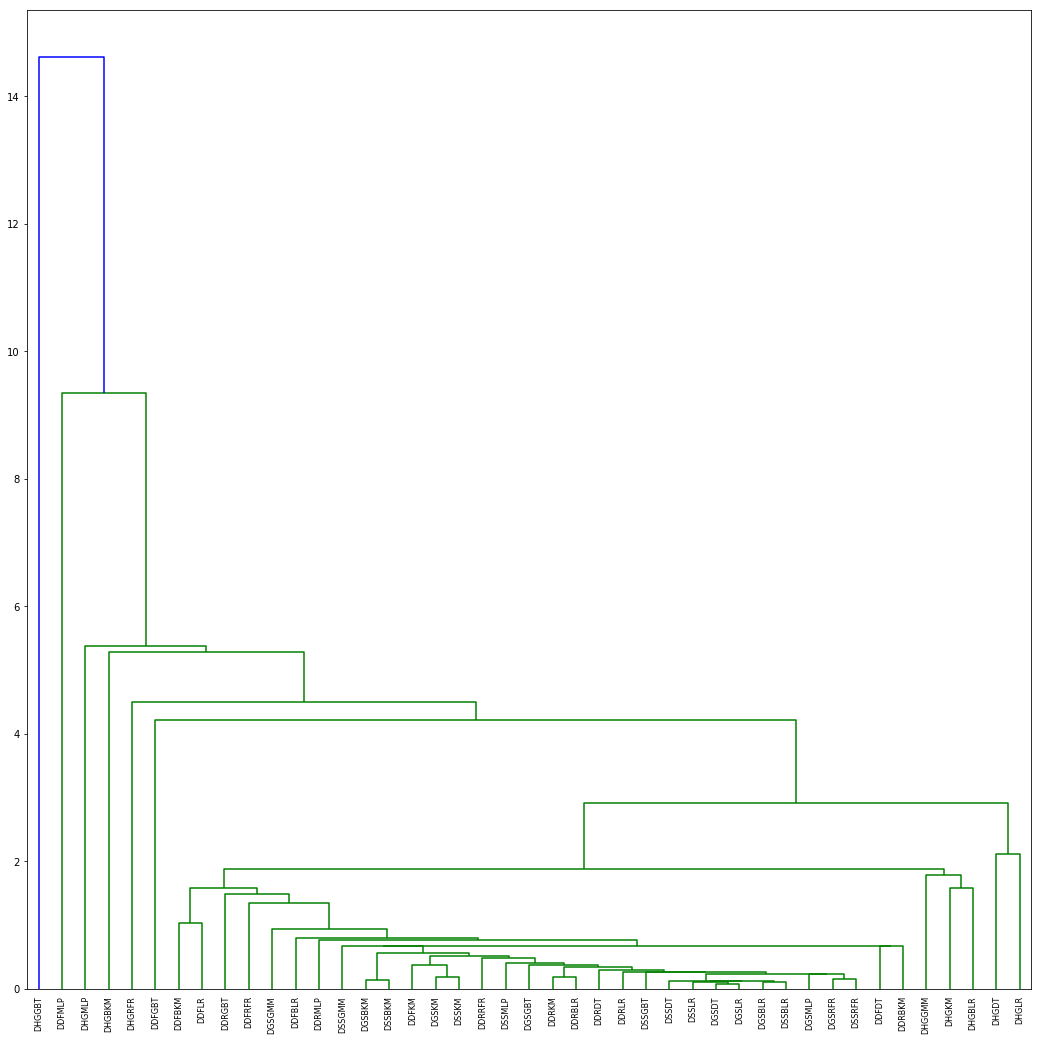

In [27]:
linked = linkage(x, 'single')

plt.figure(figsize=(18, 18))  
dendrogram(linked,  
           labels=labels,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True,
            show_contracted=True,
            truncate_mode='mtica')
plt.show()  

# After PCA

In [34]:
pca = PCA(n_components=len(features))
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component {}'.format(i) for i in range(1, len(features) + 1)])
principalDf = principalDf[['principal component 1', 'principal component 2','principal component 3']]
principalDf.head()

,principal component 1,principal component 2,principal component 3
0,2.111429,5.912861,0.192742
1,0.431700,0.856524,-0.682873
2,0.211031,1.580474,-0.463497
3,4.641006,10.167280,0.986056
4,1.779200,0.650239,-0.837242


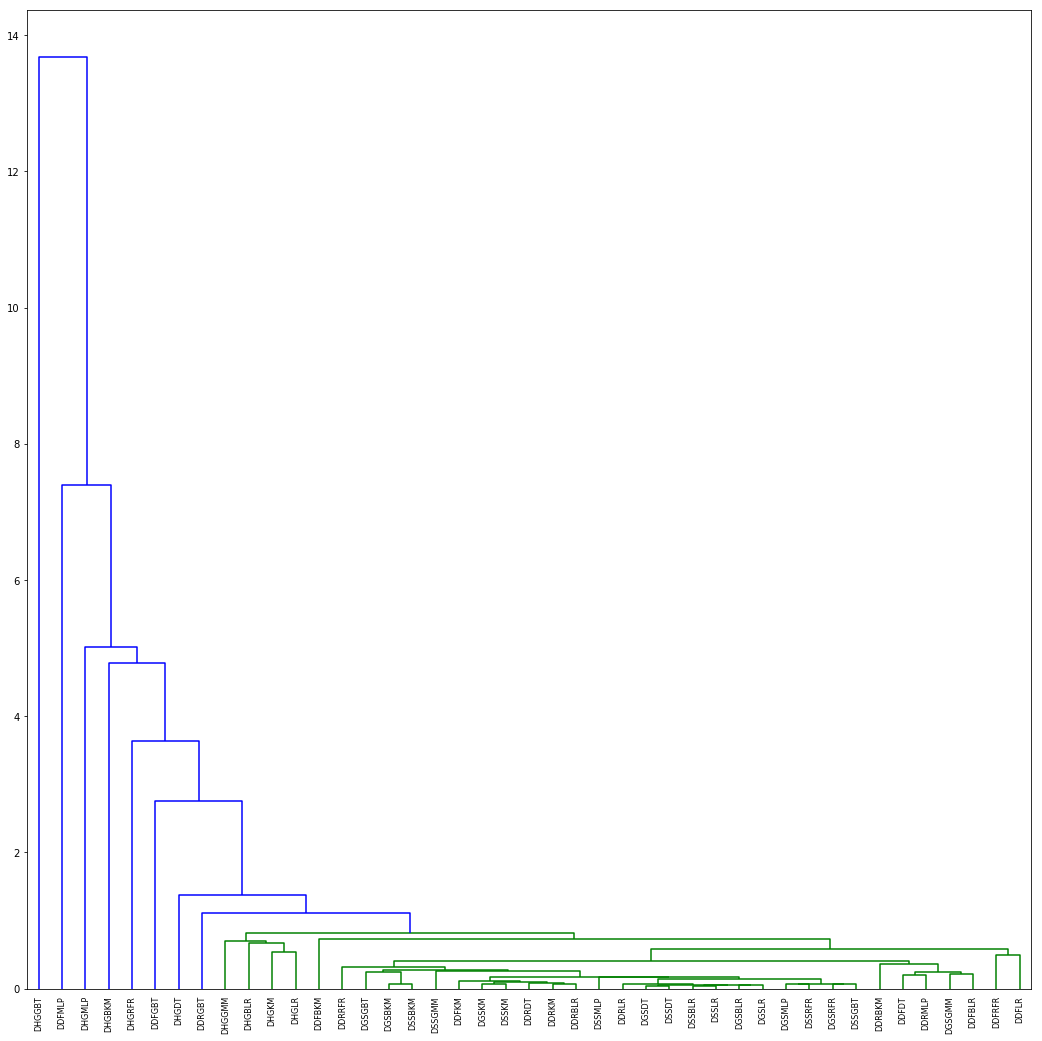

In [41]:
linked = linkage(principalDf, 'single')

plt.figure(figsize=(18, 18))  
dendrogram(linked,  
           labels=labels,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True,
            show_contracted=True,
            truncate_mode='mtica',
            color_threshold=1)
plt.show()  

We can cleasrly see two clusters, one forthe DHG dataset, the other for the other workloads

The first observation is that the dataset is the factor that impacts the most the clustering of the workloads, more than the algorithm, as confirmed with the PCA

In the green cluster, we can see a lot of sub cluster forming:
one for the DHG
We can see that with the DGS and the DSS datasets, the LR and BLR are similar
Also, there is a subcluster that involves KMeans algorithms for all datasets except DHG,stating that the KM algorithm is compute-bound and not memory-bound
RFR and GBT are frequently clustered together, and separately under each dataset, meaning that they behave the same (Tree-based) and that they are sensitive to the dataset complexity.

If we consider DSS and DGS as being equivalent (which they are), we can see that at the first clustering iteration, more than 83% (10/12) of clusters consist of clusters that are based on the same dataset.

The workloads implementing the same algorithm do not frequently get clustered together in the first clustering iteration. Only 25% do (DGS-BKM & DSS-BKM, DGSKM & DSS-KM, DGS-DT & DSS-DT). If we consider the DSS and DGS datasets as being the same, and thus ignore those cases, we see that algorithms never get clustered together.

Higher linkage distances map to higher data complexity and size. These distances are up to more than 13, whereas the majority of the other distances fall under the distance of 1, describing at least x13 in workload heterogeneity